In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [2]:
xls_data=pd.read_excel("./table.xlsx")

In [3]:
t2_dat=xls_data.loc[:,"# of turns":"HFSS"]

In [4]:
t3_dat=xls_data.loc[:,"# of turns.1":"HFSS.1"]

In [5]:
t4_dat=xls_data.loc[:,"# of turns.2":"HFSS.2"]

In [6]:
t2_dat=t2_dat.replace(np.nan,0)
t3_dat=t3_dat.replace(np.nan,0)
t4_dat=t4_dat.replace(np.nan,0)

In [7]:
def data_restore(dat):
    for col_name in dat.columns[:5]:
        temp=0
        for i in range(len(dat[col_name])):
            if (dat.loc[i,col_name]!=0):
                temp=dat.loc[i,col_name]
            if (dat.loc[i,col_name]==0):
                dat.loc[i,col_name]=temp
    return dat

In [8]:
t2_dat=data_restore(t2_dat)
t3_dat=data_restore(t3_dat)
t4_dat=data_restore(t4_dat)

In [9]:
total_dat_temp=np.vstack([t2_dat.values, t3_dat.values,t4_dat.values])

In [10]:
del_index=np.where(total_dat_temp[:,6]==0)[0]

In [11]:
total_dat_temp=pd.DataFrame(total_dat_temp,columns=t2_dat.columns)

In [12]:
total_dat=total_dat_temp.drop(del_index)

In [13]:
total_dat.to_csv("preprocessed_data.csv",
                 columns=total_dat.columns,sep=",", index=False)

In [14]:
data=total_dat.values
data=np.delete(data, 100, axis=0)

In [15]:
log_dat_x=np.log(data[:,:6])

In [16]:
log_dat_y=np.log(data[:,6])

In [17]:
x_train=log_dat_x

In [18]:
max_x=np.max(x_train, axis=0)

In [19]:
x_train=x_train/ max_x

In [20]:
max_y=np.max(log_dat_y)

In [21]:
y_train=log_dat_y/max_y

In [22]:
x_train=torch.FloatTensor(x_train)
y_train=torch.FloatTensor(y_train)

In [33]:
gamma_vals = np.logspace(-3,1,100)

mse = []
card = []
for val in gamma_vals:
    
    nb_epochs = 2000
    model=nn.Linear(6,1)
    optimizer = torch.optim.SGD(model.parameters(),lr=0.05,weight_decay=val)
    for epoch in range(nb_epochs+1):

        prediction = torch.squeeze(model(x_train))
        regularity =  torch.norm(model.weight, p=1)
        loss = F.mse_loss(prediction, y_train)
        cost = loss
        optimizer.zero_grad()
        cost.backward()
        optimizer.step()
    theta=(model.weight).detach().numpy()
    _,theta_ind=np.nonzero(abs(theta)>1e-6)
    mse.append(loss.item())
    card.append(np.sum(theta[0,[theta_ind]]))


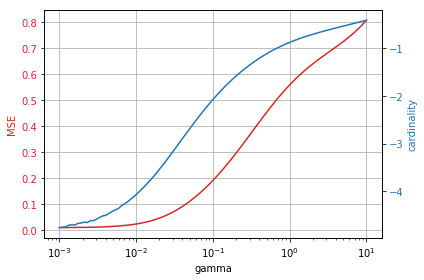

In [34]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel(r'gamma')
ax1.set_ylabel('MSE', color=color)
ax1.semilogx(gamma_vals, mse, color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid()

ax2 = ax1.twinx() 

color = 'tab:blue'
ax2.set_ylabel('cardinality', color=color)  
ax2.semilogx(gamma_vals, card, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  
plt.show()

In [25]:
nb_epochs = 1000
model=nn.Linear(6,1)
val=0.001
optimizer = torch.optim.SGD(model.parameters(),lr=0.1)
for epoch in range(nb_epochs+1):

    prediction = torch.squeeze(model(x_train))
    regularity =  torch.norm(model.weight, p=1)
    loss = F.mse_loss(prediction, y_train)
    cost = loss + val*regularity
    optimizer.zero_grad()
    cost.backward()
    optimizer.step()
    
    if epoch % 100 == 0:
        print('Epoch {:4d}/{} Cost: {:.6f}'.format(
              epoch, nb_epochs, cost.item()
          ))

Epoch    0/1000 Cost: 2.875803
Epoch  100/1000 Cost: 0.145933
Epoch  200/1000 Cost: 0.073708
Epoch  300/1000 Cost: 0.045015
Epoch  400/1000 Cost: 0.030741
Epoch  500/1000 Cost: 0.023330
Epoch  600/1000 Cost: 0.019347
Epoch  700/1000 Cost: 0.017199
Epoch  800/1000 Cost: 0.016039
Epoch  900/1000 Cost: 0.015412
Epoch 1000/1000 Cost: 0.015073


In [26]:
x=np.squeeze(model(x_train).detach().numpy())

In [27]:
y=y_train.detach().numpy()

<function matplotlib.pyplot.show(*args, **kw)>

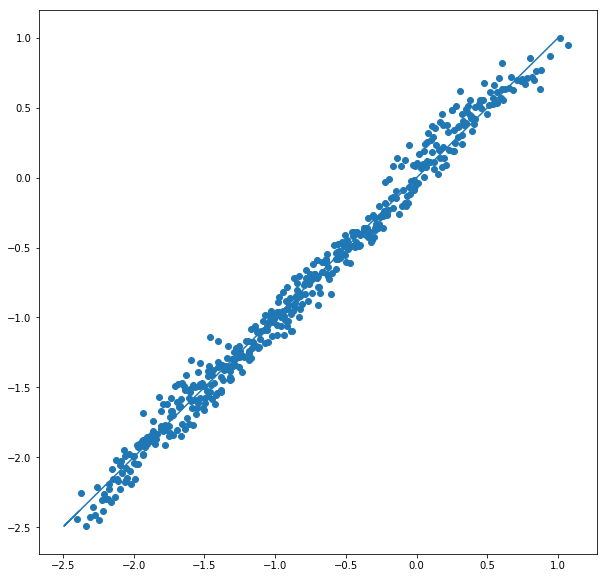

In [28]:
plt.figure(figsize=(10,10))
plt.plot(y,y)
plt.scatter(x, y)
plt.show

In [29]:
print('Percentage error:', (np.exp(np.sqrt(cost.item()))-1)*100,'%')

Percentage error: 13.062723546947641 %


In [30]:
print(list(model.parameters()))

[Parameter containing:
tensor([[-0.9307, -0.2285, -0.1382, -0.0443, -0.3958, -3.0917]],
       requires_grad=True), Parameter containing:
tensor([2.6148], requires_grad=True)]
